In [1]:
import collections
import glob
import json
import os

import numpy as np
import pandas as pd
from plotnine import *

from saged import utils

In [2]:
data_dir = '../../data'

In [3]:
metadata_path = os.path.join(data_dir, 'aggregated_metadata.json')
metadata = None
with open(metadata_path) as json_file:
    metadata = json.load(json_file)
sample_metadata = metadata['samples']

In [4]:
experiments = metadata['experiments']
sample_to_study = {}
for study in experiments:
    for accession in experiments[study]['sample_accession_codes']:
        sample_to_study[accession] = study

In [5]:
in_files = glob.glob('../../results/impute.*')
print(in_files[:5])

['../../results/impute.three_layer_impute.refinebio_labeled_dataset.3.uncorrected.tsv', '../../results/impute.three_layer_impute.refinebio_labeled_dataset.4.tsv', '../../results/impute.three_layer_impute.refinebio_labeled_dataset.1.tsv', '../../results/impute.three_layer_impute.refinebio_labeled_dataset.3.tsv', '../../results/impute.three_layer_impute.refinebio_labeled_dataset.1.uncorrected.tsv']


In [6]:
metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    
    model_info = path.strip('.tsv').split('results/impute.')[-1]
    model_info = model_info.split('.')
        
    if len(model_info) == 4:
        unsupervised_model = model_info[0]
        supervised_model = model_info[1]
        seed = model_info[3]
    else:
        unsupervised_model = 'untransformed'
        supervised_model = model_info[0]
        seed = model_info[2]
             
    new_df['unsupervised'] = unsupervised_model
    new_df['supervised'] = supervised_model
        
    metrics = pd.concat([metrics, new_df])
    
metrics = metrics.reset_index()
metrics['trial'] = metrics.index // 10
metrics.head()

,index,val_loss,train studies,train samples,val samples,train sample count,fraction of data used,unsupervised,supervised,trial
0,0,3.781908e+08,"GSE56768,GSE112811,GSE33341,GSE31348,GSE42305,...","GSM2458699,GSM301070,GSM2112193,SRR6870343,GSM...","E-MEXP-3567-C13,E-MEXP-3567-H_C08,E-MEXP-3567-...",804,0.1,three_layer_impute,refinebio_labeled_dataset,0
1,1,3.454392e+08,"GSE56768,GSE112811,GSE38511,GSE33341,GSE31348,...","GSM2458699,GSM301070,GSM2112193,SRR6870343,GSM...","E-MEXP-3567-C13,E-MEXP-3567-H_C08,E-MEXP-3567-...",1609,0.2,three_layer_impute,refinebio_labeled_dataset,0
2,2,3.456896e+08,"GSE56768,GSE112811,GSE38511,GSE33341,GSE31348,...","GSM2458699,GSM301070,GSM2112193,SRR6870343,GSM...","E-MEXP-3567-C13,E-MEXP-3567-H_C08,E-MEXP-3567-...",2413,0.3,three_layer_impute,refinebio_labeled_dataset,0
3,3,3.195609e+08,"GSE56768,GSE112811,GSE38511,GSE33341,GSE31348,...","GSM2458699,GSM301070,GSM2112193,SRR6870343,GSM...","E-MEXP-3567-C13,E-MEXP-3567-H_C08,E-MEXP-3567-...",3218,0.4,three_layer_impute,refinebio_labeled_dataset,0
4,4,3.370553e+08,"GSE56768,GSE112811,GSE38511,GSE33341,GSE31348,...","GSM2458699,GSM301070,GSM2112193,SRR6870343,GSM...","E-MEXP-3567-C13,E-MEXP-3567-H_C08,E-MEXP-3567-...",4023,0.5,three_layer_impute,refinebio_labeled_dataset,0


## A note on the "trial" variable:
The loss between different training/val dataset splits is difficult to compare. As a result, I've grouped models together by whether they were produced by the same dataset split/seed. All ten points within the same trial correspond to models trained on increasingly large subsets of the same original training dataset, validated on identical validation sets.

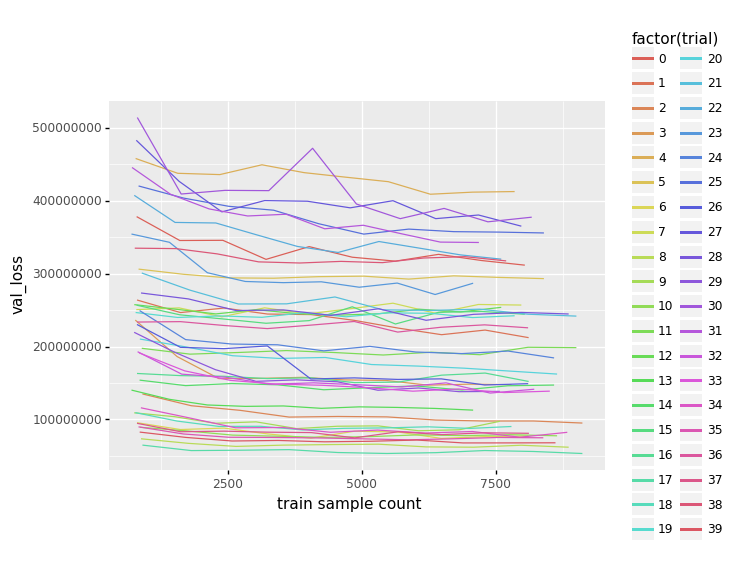

<ggplot: (8741732307432)>

In [7]:
ggplot(metrics, aes(x='train sample count', y='val_loss', color='factor(trial)')) + geom_line()

## Center trials
To make the trend easier to see, center trial to have a mean of zero

In [8]:
mean_centered_metrics = metrics.copy()
mean_centered_metrics['val_loss'] = (mean_centered_metrics['val_loss'] - 
                                     mean_centered_metrics.groupby('trial').transform('mean')['val_loss'])
mean_centered_metrics.head()

,index,val_loss,train studies,train samples,val samples,train sample count,fraction of data used,unsupervised,supervised,trial
0,0,4.603213e+07,"GSE56768,GSE112811,GSE33341,GSE31348,GSE42305,...","GSM2458699,GSM301070,GSM2112193,SRR6870343,GSM...","E-MEXP-3567-C13,E-MEXP-3567-H_C08,E-MEXP-3567-...",804,0.1,three_layer_impute,refinebio_labeled_dataset,0
1,1,1.328054e+07,"GSE56768,GSE112811,GSE38511,GSE33341,GSE31348,...","GSM2458699,GSM301070,GSM2112193,SRR6870343,GSM...","E-MEXP-3567-C13,E-MEXP-3567-H_C08,E-MEXP-3567-...",1609,0.2,three_layer_impute,refinebio_labeled_dataset,0
2,2,1.353095e+07,"GSE56768,GSE112811,GSE38511,GSE33341,GSE31348,...","GSM2458699,GSM301070,GSM2112193,SRR6870343,GSM...","E-MEXP-3567-C13,E-MEXP-3567-H_C08,E-MEXP-3567-...",2413,0.3,three_layer_impute,refinebio_labeled_dataset,0
3,3,-1.259771e+07,"GSE56768,GSE112811,GSE38511,GSE33341,GSE31348,...","GSM2458699,GSM301070,GSM2112193,SRR6870343,GSM...","E-MEXP-3567-C13,E-MEXP-3567-H_C08,E-MEXP-3567-...",3218,0.4,three_layer_impute,refinebio_labeled_dataset,0
4,4,4.896682e+06,"GSE56768,GSE112811,GSE38511,GSE33341,GSE31348,...","GSM2458699,GSM301070,GSM2112193,SRR6870343,GSM...","E-MEXP-3567-C13,E-MEXP-3567-H_C08,E-MEXP-3567-...",4023,0.5,three_layer_impute,refinebio_labeled_dataset,0


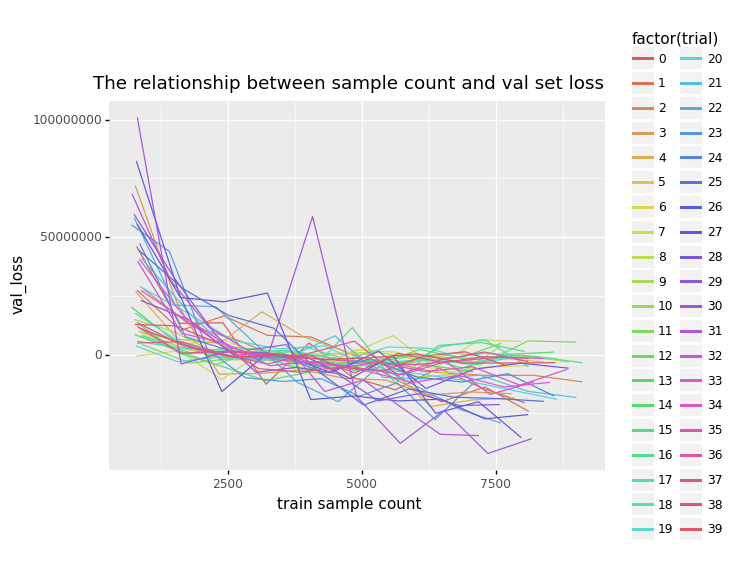

<ggplot: (8741596942978)>


In [9]:
plot = ggplot(mean_centered_metrics, aes(x='train sample count', y='val_loss', color='factor(trial)'))
plot += geom_line()
plot += ggtitle('The relationship between sample count and val set loss')
print(plot)

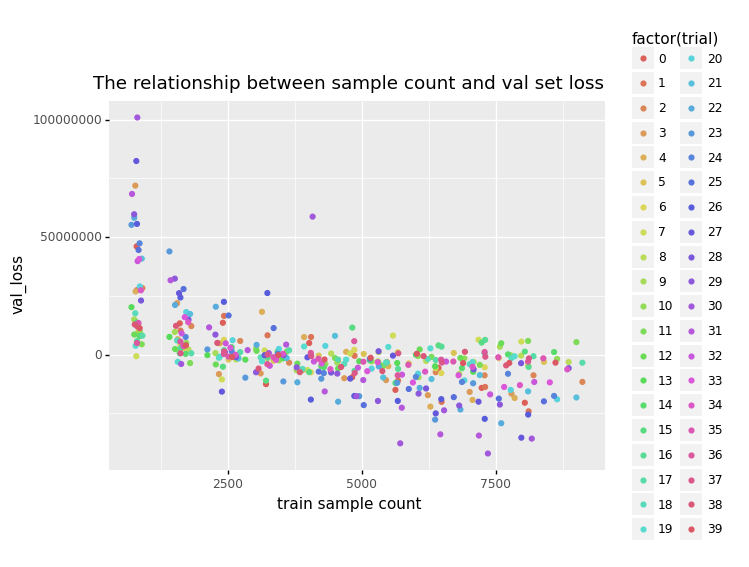

<ggplot: (8741596942900)>


In [10]:
plot = ggplot(mean_centered_metrics, aes(x='train sample count', y='val_loss', color='factor(trial)')) 
plot += geom_point()
plot += ggtitle('The relationship between sample count and val set loss')
print(plot)

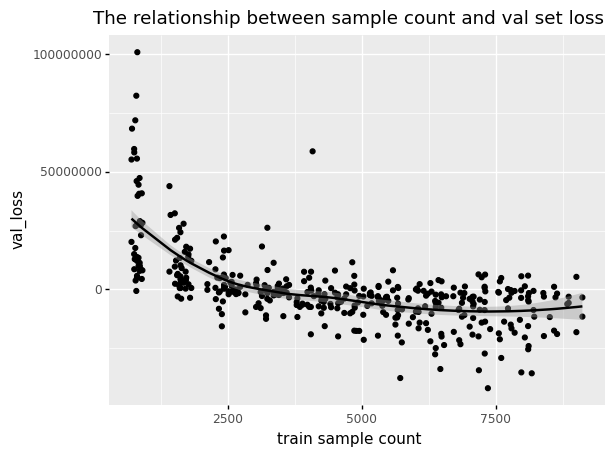

<ggplot: (8741596987844)>


In [11]:
plot = ggplot(mean_centered_metrics, aes(x='train sample count', y='val_loss')) 
plot += geom_point()
plot += geom_smooth(method='loess')
plot += ggtitle('The relationship between sample count and val set loss')
print(plot)

## Evaluate Transfering Models

In [12]:
in_files = glob.glob('../../results/transfer.*')
print(in_files[:5])

['../../results/transfer.sepsis.three_layer_impute.refinebio_labeled_dataset.1.be_corrected.tsv.backup', '../../results/transfer.tb.three_layer_impute.refinebio_labeled_dataset.2.be_corrected.tsv', '../../results/transfer.sepsis.three_layer_impute.refinebio_labeled_dataset.3.be_corrected.tsv.backup', '../../results/transfer.sepsis.three_layer_impute.refinebio_labeled_dataset.2.be_corrected.tsv', '../../results/transfer.sepsis.three_layer_impute.refinebio_labeled_dataset.2.be_corrected.tsv.backup']


In [17]:
metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    
    model_info = path.strip('.tsv').split('results/impute.')[-1]
    model_info = model_info.split('.')        

    supervised_model = model_info[4]
    seed = model_info[6]
    disease = model_info[3]
             
    new_df['supervised'] = supervised_model
    new_df['seed'] = seed
    new_df['disease'] = disease
        
    metrics = pd.concat([metrics, new_df])
    
metrics = metrics.reset_index()
metrics['trial'] = metrics.index // 20
metrics

,index,accuracy,balanced_accuracy,f1_score,train studies,train samples,val samples,train sample count,fraction of data used,impute_samples,supervised,seed,disease,trial
0,0,0.285714,0.500000,0.444444,"GSE33580,GSE66890,GSE33118,SRP092402,GSE83456,...","GSM2449616,GSM830222,GSM265033,GSM830186,GSM13...","GSM1050991,GSM1051012,GSM1051015,GSM1051020,GS...",192,0.1,0,three_layer_impute,1,sepsis,0
1,1,0.293740,0.500562,0.443038,"GSE33580,GSE66890,GSE33118,SRP092402,GSE83456,...","GSM2449616,GSM830222,GSM265033,GSM830186,GSM13...","GSM1050991,GSM1051012,GSM1051015,GSM1051020,GS...",192,0.1,711,three_layer_impute,1,sepsis,0
2,2,0.335474,0.489326,0.421788,"GSE33580,GSE66890,GSE33118,SRP092402,GSE83456,...","GSM2449616,GSM830222,GSM265033,GSM830186,GSM13...","GSM1050991,GSM1051012,GSM1051015,GSM1051020,GS...",192,0.1,10234,three_layer_impute,1,sepsis,0
3,3,0.956661,0.941011,0.922636,"GSE33580,GSE66890,GSE33118,SRP092402,GSE5504,G...","GSM2449616,GSM830222,GSM265033,GSM830186,GSM13...","GSM1050991,GSM1051012,GSM1051015,GSM1051020,GS...",385,0.2,0,three_layer_impute,1,sepsis,0
4,4,0.977528,0.975843,0.961111,"GSE33580,GSE66890,GSE33118,SRP092402,GSE5504,G...","GSM2449616,GSM830222,GSM265033,GSM830186,GSM13...","GSM1050991,GSM1051012,GSM1051015,GSM1051020,GS...",385,0.2,711,three_layer_impute,1,sepsis,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,145,0.866667,0.848693,0.822086,"GSE93777,GSE95233,GSE40586,GSE21592,GSE14844,G...","SRR3235939,GSM2500410,GSM648655,GSM2631038,GSM...","GSM1253056,GSM1253057,GSM1253058,GSM1253059,GS...",2403,0.9,711,three_layer_impute,4,sepsis,80
1616,146,0.894253,0.881209,0.863095,"GSE93777,GSE95233,GSE40586,GSE21592,GSE14844,G...","SRR3235939,GSM2500410,GSM648655,GSM2631038,GSM...","GSM1253056,GSM1253057,GSM1253058,GSM1253059,GS...",2403,0.9,10234,three_layer_impute,4,sepsis,80
1617,147,0.820690,0.793954,0.746753,"GSE93777,GSE95233,GSE40586,GSE21592,GSE14844,G...","SRR3235939,GSM2500410,GSM648655,GSM2631038,GSM...","GSM1253056,GSM1253057,GSM1253058,GSM1253059,GS...",2671,1.0,0,three_layer_impute,4,sepsis,80
1618,148,0.806897,0.778105,0.723684,"GSE93777,GSE95233,GSE40586,GSE21592,GSE14844,G...","SRR3235939,GSM2500410,GSM648655,GSM2631038,GSM...","GSM1253056,GSM1253057,GSM1253058,GSM1253059,GS...",2671,1.0,711,three_layer_impute,4,sepsis,80


In [18]:
sepsis_df = metrics[metrics['disease'] == 'sepsis']
tb_df = metrics[metrics['disease'] == 'tb']

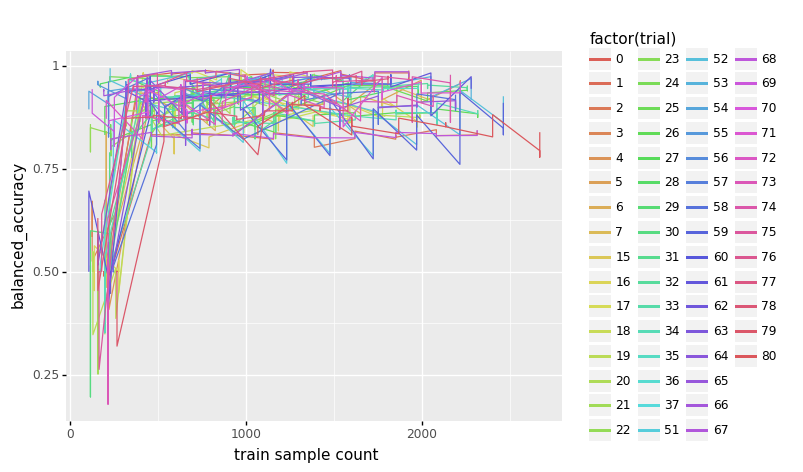

<ggplot: (8741545888738)>

In [19]:
ggplot(sepsis_df, aes(x='train sample count', y='balanced_accuracy', color='factor(trial)')) + geom_line()

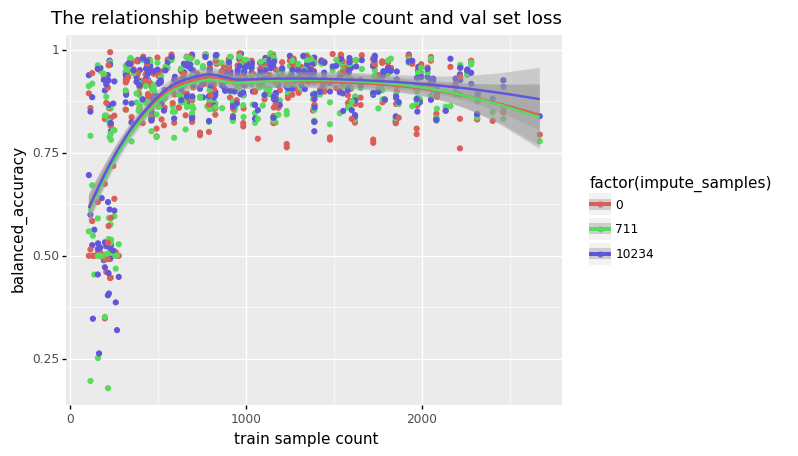

<ggplot: (8741595218836)>


In [20]:
plot = ggplot(sepsis_df, aes(x='train sample count', y='balanced_accuracy', color='factor(impute_samples)')) 
plot += geom_point()
plot += geom_smooth(method='loess')
plot += ggtitle('The relationship between sample count and val set loss')
print(plot)

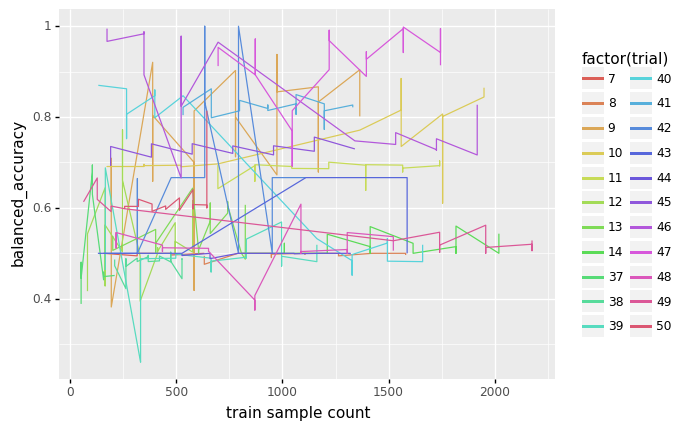

<ggplot: (8741545689935)>

In [21]:
ggplot(tb_df, aes(x='train sample count', y='balanced_accuracy', color='factor(trial)')) + geom_line()

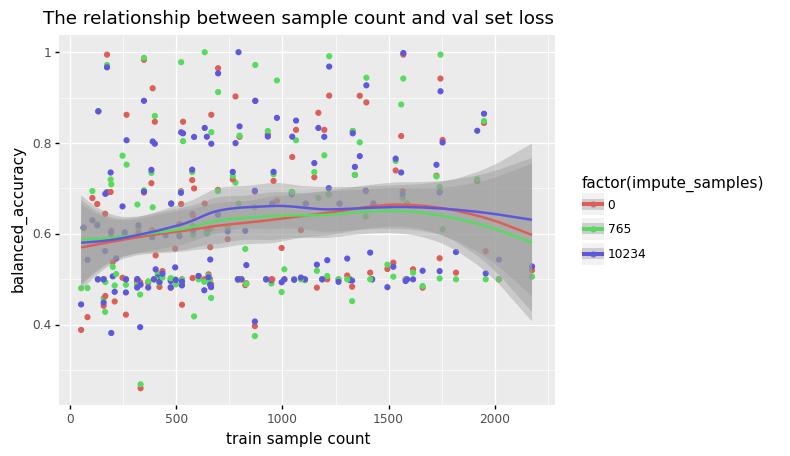

<ggplot: (8741545691889)>


In [22]:
plot = ggplot(tb_df, aes(x='train sample count', y='balanced_accuracy', color='factor(impute_samples)')) 
plot += geom_point()
plot += geom_smooth(method='loess')
plot += ggtitle('The relationship between sample count and val set loss')
print(plot)